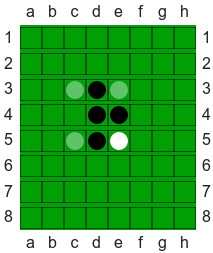
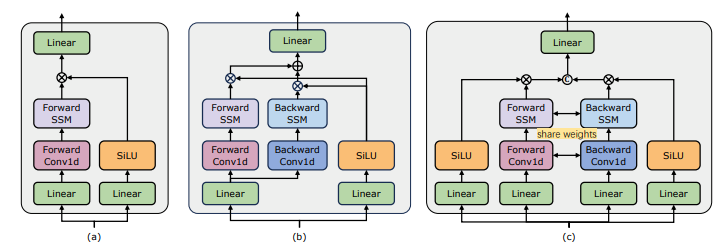

https://github.com/alxndrTL/othello_mamba

https://github.com/kyegomez/zeta

In [2]:
!pip install -q -U git+https://github.com/fabienfrfr/Mamba-Bis.git@main
#mambapy comparizon
!pip install -q mambapy==1.0.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [3]:
import torch, os
from mamba_bis.mambabis import MambaConfig, BiMamba
from mamba_bis.mambalm import BiMambaLM
from mamba_bis.othello import OthelloDataset
#mambapy comparizon
from mambapy.mamba_lm import MambaLM, MambaLMConfig

In [4]:
# Model config
vocab_size = 65 # Othello
d_model = 256 # 288 for 
n_layers = 8
d_state = 16
dim_inner = 256 #2 * d_state
# MambaConfig(dim=256, dt_rank=32, d_inner=256, d_state=16, depth=8, expand_factor=2, d_conv=4, rms_norm_eps=1e-05) 
# MambaPyConfig(d_model=256, n_layers=8, dt_rank=16, d_state=16, expand_factor=2, d_conv=4, rms_norm_eps=1e-05)
config = MambaConfig(dim=d_model, depth=n_layers, d_state=d_state, d_inner=dim_inner)

# Dataset config
batch_size = 256

# Training config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay = 0.1
lr = 1e-3
adam_b1 = 0.9
adam_b2 = 0.95
dtype = "bfloat16"

In [7]:
# Download Othello Dataset from HugginFace
#from datasets import load_dataset
#dataset = load_dataset("alexandretl/othello")
!wget -O data.tar.xz https://huggingface.co/datasets/alexandretl/othello/resolve/main/data.tar.xz?download=true
!tar -xf data.tar.xz # (1-2 minutes, 240 files)

--2024-07-27 15:13:31--  https://huggingface.co/datasets/alexandretl/othello/resolve/main/data.tar.xz?download=true
Resolving huggingface.co (huggingface.co)... 54.230.71.28, 54.230.71.103, 54.230.71.56, ...
Connecting to huggingface.co (huggingface.co)|54.230.71.28|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/74/56/74560841d7258529c172b2b966b8905c5e99b01edf64ea997a2e464b2f32d7c5/5522edc3cd8f3f9181a56390018135e29ba6039e15701c3750a9b309a913ba3d?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27data.tar.xz%3B+filename%3D%22data.tar.xz%22%3B&response-content-type=application%2Fx-xz&Expires=1722352411&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMjM1MjQxMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzc0LzU2Lzc0NTYwODQxZDcyNTg1MjljMTcyYjJiOTY2Yjg5MDVjNWU5OWIwMWVkZjY0ZWE5OTdhMmU0NjRiMmYzMmQ3YzUvNTUyMmVkYzNjZDhmM2Y5MTgxYTU2Mzkw

In [5]:
!tree -d

.

0 directories


In [9]:
# Construct dataset
train_dataset = OthelloDataset('data/train')
val_dataset = OthelloDataset('data/val')
# Construct loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
iter_val = iter(val_loader)

In [10]:
for iter, data in enumerate(val_loader):
    print(iter)
    x,y = data
    break
x.shape

0


torch.Size([256, 59])

In [5]:
# fake input
x = torch.randint(high=vocab_size, size=(256, 59))
x.shape

torch.Size([256, 59])

In [6]:
# Initialize model
model = BiMambaLM(config, vocab_size=vocab_size+7).to(device)
optim = model.configure_optimizers(weight_decay, lr, (adam_b1, adam_b2), device) # AdamW optim with weight_decay except for 1D params (biases, norms)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype=="float16")) # needed when training with float16

In [7]:
model

BiMambaLM(
  (embedding): Embedding(72, 256, padding_idx=0)
  (core): BiMamba(
    (layers): ModuleList(
      (0-7): 8 x BiMambaBlock(
        (shared_conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (silu): SiLU()
        (ssm): SSM(
          (x_proj): Linear(in_features=512, out_features=48, bias=False)
          (dt_proj): Linear(in_features=16, out_features=512, bias=True)
        )
        (proj): Linear(in_features=256, out_features=1024, bias=False)
        (softplus): Softplus(beta=1, threshold=20)
      )
    )
  )
  (out_norm): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=72, bias=False)
)

In [8]:
logits = model(x) # (B, L, vocab_size)

RuntimeError: Given groups=512, weight of size [512, 1, 4], expected input[256, 1024, 59] to have 512 channels, but got 1024 channels instead

In [8]:
# mambapy comparizon
config_ = MambaLMConfig(d_model=d_model, n_layers=n_layers, vocab_size=vocab_size)
model_ = MambaLM(config_)
print(model_, model_.config)

MambaLM(
  (embedding): Embedding(72, 256)
  (mamba): Mamba(
    (layers): ModuleList(
      (0-7): 8 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=256, out_features=1024, bias=False)
          (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
          (x_proj): Linear(in_features=512, out_features=48, bias=False)
          (dt_proj): Linear(in_features=16, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (norm_f): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=72, bias=False)
) MambaConfig(d_model=256, n_layers=8, dt_rank=16, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, rms_norm_eps=1e-05, bias=False, conv_bias=True, inner_layernorms=False, pscan=True, use_cuda=False)


BiMambaLM(
  (embedding): Embedding(72, 256, padding_idx=0)
  (core): BiMamba(
    (layers): ModuleList(
      (0-7): 8 x BiMambaBlock(
        (shared_conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (silu): SiLU()
        (ssm): SSM(
          (x_proj): Linear(in_features=512, out_features=48, bias=False)
          (dt_proj): Linear(in_features=16, out_features=512, bias=True)
        )
        (proj): Linear(in_features=256, out_features=1024, bias=False)
        (softplus): Softplus(beta=1, threshold=20)
      )
    )
  )
  (out_norm): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=72, bias=False)

In [ ]:
logits = model_(x) # (B, L, vocab_size)
logits.shape

In [ ]:
count_parameters = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

In [ ]:
model = torch.compile(model)

In [19]:
# Train model (TO DO)
out = model(x.to(device, non_blocking=True))

RuntimeError: The size of tensor a (61) must match the size of tensor b (64) at non-singleton dimension 1

In [ ]:
# Evaluate model (dummy)
x = torch.randint(high=vocab_size, size=(256, 59)) # torch.randint(high=vocab_size, size=(16, 64))
out = model(x)
print(out.shape)  # Print the shape of the output tensor

## To modify :